In [1]:
import pandas as pd
import numpy as np
import time
import requests
import matplotlib.pyplot as plt
import terminalLogic
from terminalLogic import Algo
import client
from client import FtxClient

from typing import Optional, Dict, Any, List
from ciso8601 import parse_datetime
from requests import Request, Session, Response
import sys
import hmac
import urllib.parse
import time
import plotly.graph_objects as go
from ta import add_all_ta_features
from ta.utils import dropna
from datetime import datetime
plt.rcParams["figure.figsize"] = (100,10)


In [2]:
# df = pd.read_csv('data/btc1m.csv')

In [3]:
# btc = FtxClient()
# df = btc.get_all_markets('BTC-PERP')

In [4]:
# db=pd.json_normalize(df)

# db.to_csv('data/btc1m.csv')

In [5]:
df = pd.read_csv('btc1m.csv')

In [6]:
# df[::-1]
df = df.drop(df.columns[0], axis = 1) 
df = df[::-1]
df

,startTime,time,open,high,low,close,volume
1154285,2019-07-20T12:35:00+00:00,1.563626e+12,10564.25,10572.25,10560.50,10567.75,6.365293e+05
1154284,2019-07-20T22:11:00+00:00,1.563661e+12,10964.75,10964.75,10962.25,10963.00,0.000000e+00
1154283,2019-07-20T22:10:00+00:00,1.563661e+12,10969.25,10969.25,10964.00,10964.75,0.000000e+00
1154282,2019-07-20T22:09:00+00:00,1.563661e+12,10971.00,10972.00,10962.75,10967.25,8.616816e+05
1154281,2019-07-20T22:08:00+00:00,1.563660e+12,10974.25,10976.25,10971.00,10971.00,8.622317e+05
...,...,...,...,...,...,...,...
4,2021-09-27T20:18:00+00:00,1.632774e+12,42840.00,42861.00,42840.00,42859.00,6.825402e+05
3,2021-09-27T20:17:00+00:00,1.632774e+12,42851.00,42857.00,42830.00,42840.00,9.973960e+05
2,2021-09-27T20:16:00+00:00,1.632774e+12,42839.00,42870.00,42826.00,42851.00,1.807072e+06
1,2021-09-27T20:15:00+00:00,1.632774e+12,42810.00,42846.00,42783.00,42840.00,2.211378e+06


In [7]:
df["ma"] = df['close'].rolling(9).mean()
df['ratio'] = df['close'] / df['ma']
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(df['ratio'].dropna(), percentiles)
short = p[-1]
long = p[0]
df['position'] = np.where(df.ratio > short, -1, np.nan)
df['position'] = np.where(df.ratio < long, 1, df['position'])
df['position'] = df['position'].ffill()
df['returns'] = np.log(df["close"]).diff()
df['strat_return'] = df['returns'] * df['position'].shift()
df

,startTime,time,open,high,low,close,volume,ma,ratio,position,returns,strat_return
1154285,2019-07-20T12:35:00+00:00,1.563626e+12,10564.25,10572.25,10560.50,10567.75,6.365293e+05,NaN,NaN,NaN,NaN,NaN
1154284,2019-07-20T22:11:00+00:00,1.563661e+12,10964.75,10964.75,10962.25,10963.00,0.000000e+00,NaN,NaN,NaN,0.036719,NaN
1154283,2019-07-20T22:10:00+00:00,1.563661e+12,10969.25,10969.25,10964.00,10964.75,0.000000e+00,NaN,NaN,NaN,0.000160,NaN
1154282,2019-07-20T22:09:00+00:00,1.563661e+12,10971.00,10972.00,10962.75,10967.25,8.616816e+05,NaN,NaN,NaN,0.000228,NaN
1154281,2019-07-20T22:08:00+00:00,1.563660e+12,10974.25,10976.25,10971.00,10971.00,8.622317e+05,NaN,NaN,NaN,0.000342,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-09-27T20:18:00+00:00,1.632774e+12,42840.00,42861.00,42840.00,42859.00,6.825402e+05,42831.222222,1.000649,-1.0,0.001401,-0.001401
3,2021-09-27T20:17:00+00:00,1.632774e+12,42851.00,42857.00,42830.00,42840.00,9.973960e+05,42829.666667,1.000241,-1.0,-0.000443,0.000443
2,2021-09-27T20:16:00+00:00,1.632774e+12,42839.00,42870.00,42826.00,42851.00,1.807072e+06,42825.444444,1.000597,-1.0,0.000257,-0.000257
1,2021-09-27T20:15:00+00:00,1.632774e+12,42810.00,42846.00,42783.00,42840.00,2.211378e+06,42828.222222,1.000275,-1.0,-0.000257,0.000257


In [8]:
#column for negative and positive
df.dropna()
df['sign'] = np.where(df['strat_return'] < 0, 'neg','pos')
#consecutive groups
df['series'] = df['sign'].ne(df['sign'].shift()).cumsum()
#removed groups with length more like 2
df = df[df['series'].map(df['series'].value_counts()).gt(2)]
#tested if order `pos-neg` of groups, if not removed groups
m1 = df['sign'].eq('pos') & df['sign'].shift(-1).eq('neg')
m2 = df['sign'].eq('neg') & df['sign'].shift().eq('pos')
groups = df.loc[m1 | m2, 'series']
df = df[df['series'].isin(groups)].copy()
df['pairs'] = (df['sign'].ne(df['sign'].shift()) & df['sign'].eq('pos')).cumsum()

N = len(df['series'].dropna())
R = df['series'].dropna().nunique()
W = len(df.loc[df.strat_return.dropna() > 0])
L = len(df.loc[df.strat_return.dropna() < 0])
P = 2*W*L

# Z_score = (N*(R-0.5)-P)/((P*(P-N))/(N-1))**(1/2)
# Z_score

a = Algo(df)
b = a.Z_score(df)
b

-254.18568444090667

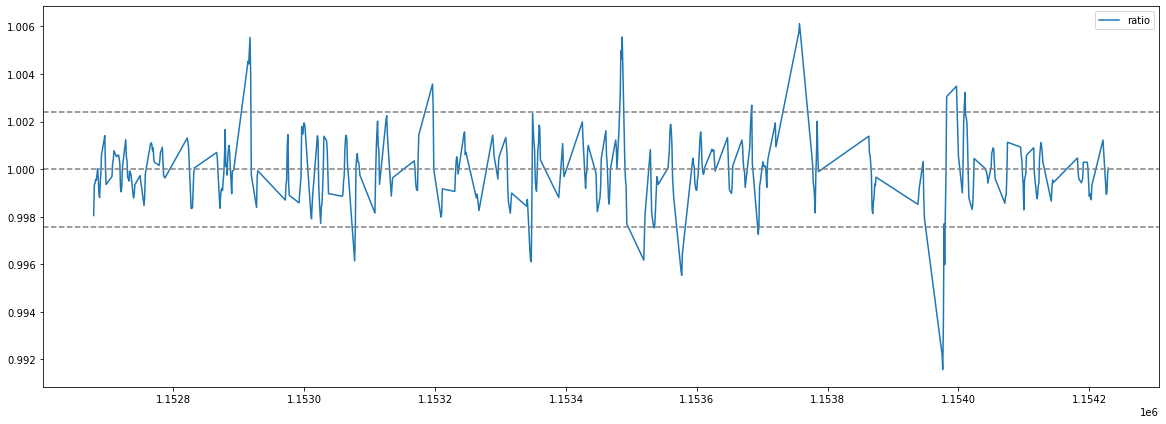

In [9]:
# visual look at ratio column
plt.rcParams["figure.figsize"] =  (20,7)

df['ratio'].head(500).dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--');
# can see ratio move around mean

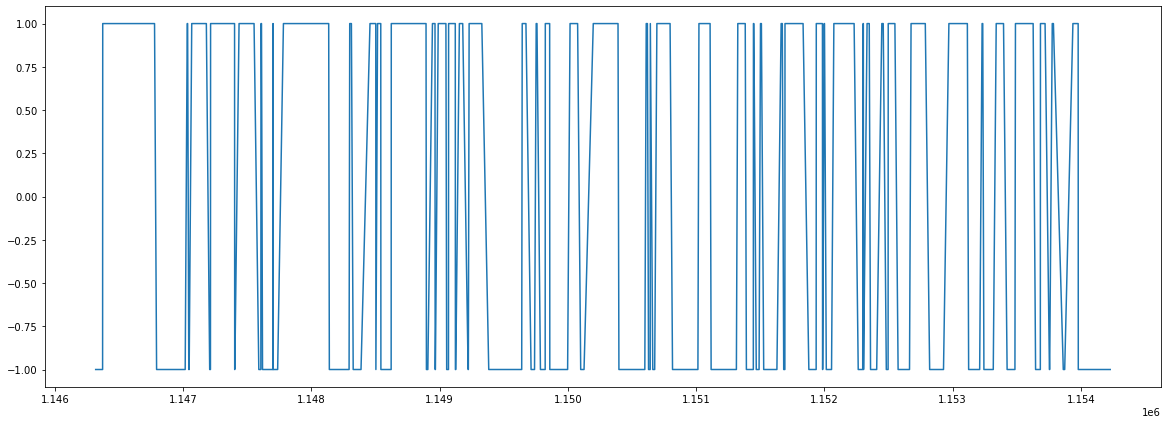

In [10]:
# df.position.dropna().plot()
plt.plot(df.head(2500).position.dropna())
plt.rcParams["figure.figsize"] = (20,7)


In [11]:
# plt.rcParams["figure.figsize"] =  (30,10)
# plt.plot(df['close'].tail(300).dropna(), label= "BTC-PERP")
# plt.plot((df['close']), (np.where(df.position > -1)), 'v', color="r", markersize=10)
# plt.plot((df['close']), (np.where(df.position < 0)),  '^', color="g", markersize=10)


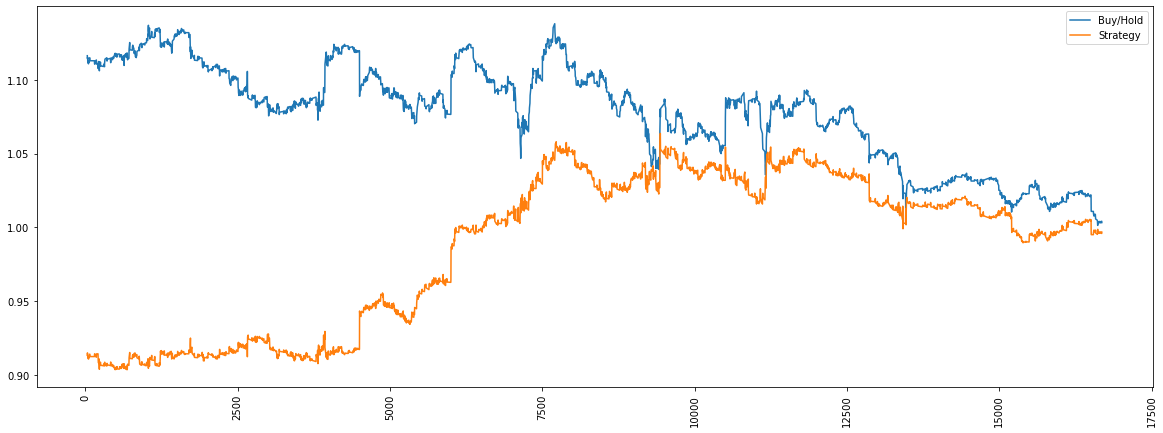

In [12]:
plt.plot(np.exp(df['returns'].tail(5000).dropna()).cumprod(), label='Buy/Hold')
plt.plot(np.exp(df['strat_return'].tail(5000).dropna()).cumprod(), label='Strategy')
plt.xticks(rotation=90)
plt.legend();

In [13]:
# # final value for each column

# print("Returns over time period specified within api call: ")
# marketR = np.exp(df['returns'].dropna()).cumprod().iloc[-1]-1
# stratR = np.exp(df['strat_return'].dropna()).cumprod().iloc[-1]-1
# percentageM = "{:.0%}".format(marketR)
# percentageS = "{:.0%}".format(stratR)
# print('Market: ', percentageM, 'Strat: ', percentageS)
# final value for each column
print("Returns over time period specified within api call: ")
print(np.exp(df['returns'].tail(5000).dropna()).cumprod().iloc[-1] -1)
print(np.exp(df['strat_return'].tail(5000).dropna()).cumprod().iloc[-1] -1)

Returns over time period specified within api call: 
0.11637255945581759
-0.08665429883053666


In [14]:
# Set initial capital
initial_capital = float(22000.0)

# Create df positions
positions = pd.DataFrame(index=df.startTime.index).fillna(0.0)


# Buy 2 BTC
positions['BTC-PERP'] = 1.5*df['position']

# Initilize portfolio w value owned
portfolio = positions.multiply(df['close'], axis=0)

# Store diff in shares owned
pos_diff = positions.diff()

# Add 'holdings' to portfolio
portfolio['holdings'] = (positions.multiply(df['close'], axis=0)).sum(axis=1)

# Add 'cash' to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(df['close'], axis=0)).sum(axis=1).cumsum()

# Add 'total' to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add 'returns' to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

portfolio['startTime'] = df['startTime']

In [15]:
portfolio

,BTC-PERP,holdings,cash,total,returns,startTime
1154229,-21846.5,-21846.5,20000.0,-1846.5,NaN,2019-07-20T21:16:00+00:00
1154228,-21839.0,-21839.0,20000.0,-1839.0,-0.004062,2019-07-20T21:15:00+00:00
1154227,-21820.5,-21820.5,20000.0,-1820.5,-0.010060,2019-07-20T21:14:00+00:00
1154226,-21816.5,-21816.5,20000.0,-1816.5,-0.002197,2019-07-20T21:13:00+00:00
1154225,-21824.5,-21824.5,20000.0,-1824.5,0.004404,2019-07-20T21:12:00+00:00
...,...,...,...,...,...,...
37,-85608.0,-85608.0,299340.0,213732.0,0.000281,2021-09-27T20:51:00+00:00
36,-85608.0,-85608.0,299340.0,213732.0,0.000000,2021-09-27T20:50:00+00:00
35,-85624.0,-85624.0,299340.0,213716.0,-0.000075,2021-09-27T20:49:00+00:00
34,-85716.0,-85716.0,299340.0,213624.0,-0.000430,2021-09-27T20:48:00+00:00


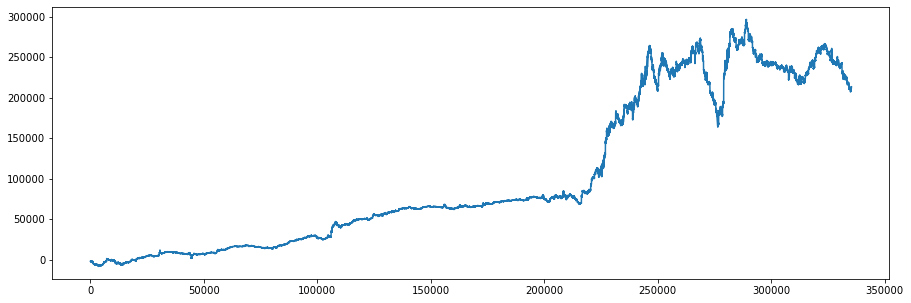

In [16]:

plt.rcParams["figure.figsize"] = (15,5)

x = portfolio['startTime']
y = portfolio['total']
values = range(len(x))
plt.plot(values,y)


# Show the plot
plt.show()

In [17]:
# df = add_all_ta_features(
#     df, open="open", high="high", low="low", close="close", volume="volume")
# df